In [2]:
import cv2 as cv
import numpy as np
import os

from PIL import Image, ImageFont, ImageDraw
import matplotlib.pyplot as plt

In [3]:
LETTER_IMG_DIM_X = 64
LETTER_IMG_DIM_Y = 80
LETTER_IMG_SHAPE = (LETTER_IMG_DIM_Y, LETTER_IMG_DIM_X)

THRESHOLD_MIN = 128
THRESHOLD_MAX = 255
letter_thresh_minHSV = (int(230/2), 128, 0)
letter_thresh_maxHSV = (int(250/2), 255, 255)

# MAX_SHIFT = 3
FONT_SIZES = [80, 85, 90, 96]
FONT_SIZE_LOCATIONS = [(11, -3), (11, -5), (10, -7), (9, -9), (7, -12)]

In [4]:
def letter_img_from(letter, font_size):
    blank_letter_color = Image.fromarray(np.full((200, 200, 3), 200, dtype=np.uint8)) #dtype required
    draw = ImageDraw.Draw(blank_letter_color, mode='RGB')
    monospace = ImageFont.truetype("train/UbuntuMono-R.ttf", font_size)
    draw.text((50, 50), letter, fill=(255,0,0), font=monospace) # When read as BGR by cv2, will become blue
    letter_img = np.array(blank_letter_color)
    return letter_img

def mangled(letter_img):
    letter_img_new = cv.medianBlur(letter_img, 11)
    cv.GaussianBlur(letter_img_new, (21,21), sigmaX=0, dst=letter_img_new)
    return letter_img_new

def letter_mask_from(img): # BGR or GRAY
    if len(img.shape) == 2:
        img_mask = cv.inRange(img, THRESHOLD_MIN, THRESHOLD_MAX)
    else:
        img_HSV = cv.cvtColor(img, cv.COLOR_BGR2HSV)
        img_mask = cv.inRange(img_HSV, letter_thresh_minHSV, letter_thresh_maxHSV)
    # contour detection
    contours, hierarchy = cv.findContours(img_mask, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    sorted_contours = tuple(sorted(contours, key = lambda x: cv.contourArea(x), reverse = True)) # largest to smallest contours
    # Take the largest contour as the letter
    contour = contours[0]
    x, y, w, h = cv.boundingRect(contour)
        
    subimg = np.copy(img_mask[y:y+h, x:x+w])
    letter_mask = np.zeros(LETTER_IMG_SHAPE, dtype=np.uint8)
    start_x = (LETTER_IMG_DIM_X - w) // 2
    start_y = (LETTER_IMG_DIM_Y - h) // 2
    letter_mask[start_y : start_y + h, start_x : start_x + w] = subimg
    return letter_mask

In [5]:
# Clear the 'train-letters' directory before running.
try:
    os.mkdir('train/train-letters/')
except(OSError):
    pass

for i in range(36):
    # For each letter, make 4*2*2 = 16 images: four font sizes x mangled/not x eroded/not
    letter = chr(ord('A') + i) if i < 26 else chr(ord('0') + i - 26)
    outpath = f'train/train-letters/{i}/'
    try:
        os.mkdir(outpath)
    except(OSError):
        pass

    j = 0
    for font_size in FONT_SIZES: # 4
        letter_img_base = letter_img_from(letter, font_size)
        letter_img_mangled = mangled(letter_img_base)
        letter_imgs = [letter_img_base, letter_img_mangled]
        for letter_img in letter_imgs: # 2
            # mask -> eroded or not
            letter_mask_base = letter_mask_from(letter_img)
            letter_mask_eroded = letter_mask_from(letter_img)
            cv.imwrite(outpath + f"{letter}_{j}.png", letter_mask_base)
            j += 1
            cv.imwrite(outpath + f"{letter}_{j}.png", letter_mask_eroded)
            j += 1

# TESTING (don't need to run)

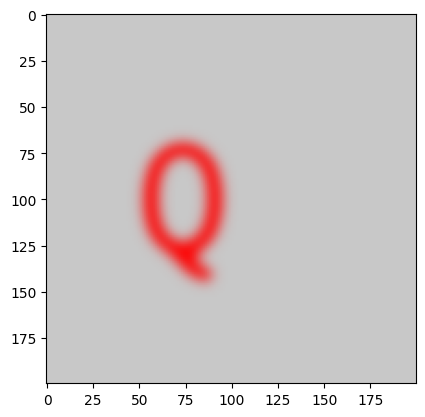

In [102]:
letter = 'Q'
font_size = 96
blank_letter_color = Image.fromarray(np.full((200, 200, 3), 200, dtype=np.uint8)) #dtype required
draw = ImageDraw.Draw(blank_letter_color, mode='RGB')
monospace = ImageFont.truetype("train/UbuntuMono-R.ttf", font_size)
draw.text((50, 50), letter, fill=(255,0,0), font=monospace)
letter_img = np.array(blank_letter_color)
letter_img = cv.medianBlur(letter_img, 11)
letter_img = cv.GaussianBlur(letter_img, (21,21), sigmaX=0)

plt.imshow(letter_img)

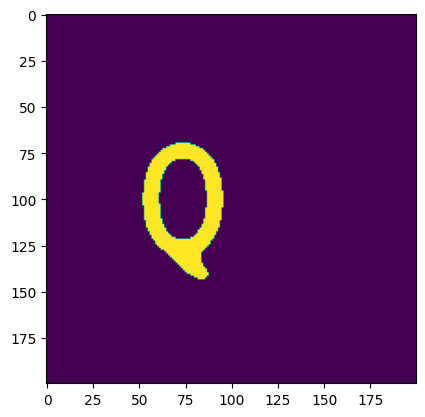

In [103]:
img_HSV = cv.cvtColor(letter_img, cv.COLOR_BGR2HSV)
img_mask = cv.inRange(img_HSV, letter_thresh_minHSV, letter_thresh_maxHSV)
plt.imshow(img_mask)

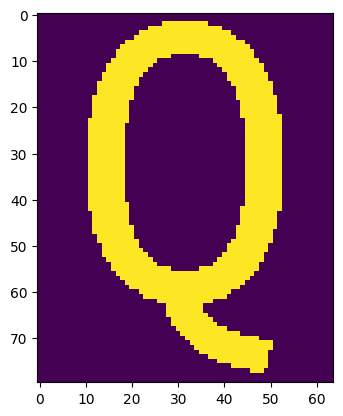

In [104]:
letter_img = letter_img_from(letter, font_size)
letter_mask = letter_mask_from(letter_img)
plt.imshow(letter_mask)

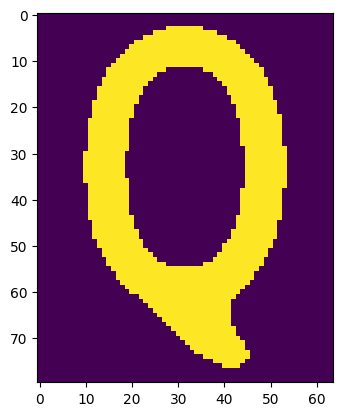

In [105]:
letter_img = letter_img_from(letter, font_size)
letter_img = mangled(letter_img)
letter_mask = letter_mask_from(letter_img)
plt.imshow(letter_mask)

### Testing with blurred images

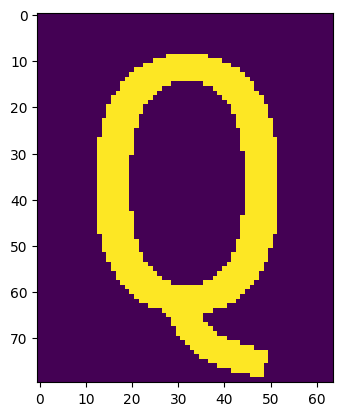

In [111]:
letter = 'Q'
blank_letter = np.zeros(LETTER_IMG_SHAPE, dtype=np.uint8)
blank_letter_pil = Image.fromarray(blank_letter)
# Get a drawing context
draw = ImageDraw.Draw(blank_letter_pil)
font_size = 90
font_location = (10, -10)
# Replace
monospace = ImageFont.truetype("train/UbuntuMono-R.ttf", font_size)
draw.text(font_location, letter, fill=255, font=monospace)
# Convert back to OpenCV image and save
letter_img = np.array(blank_letter_pil)
letter_img_thresh = cv.inRange(letter_img, 128, 255)
plt.imshow(letter_img_thresh)

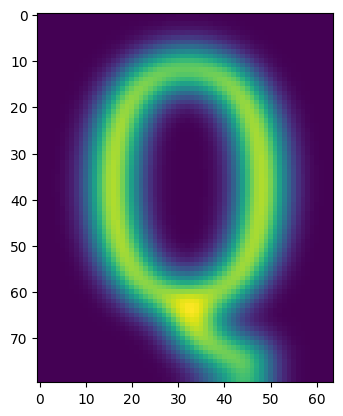

In [112]:
letter_img_blur = cv.GaussianBlur(letter_img, (21, 21), sigmaX=0)
plt.imshow(letter_img_blur)

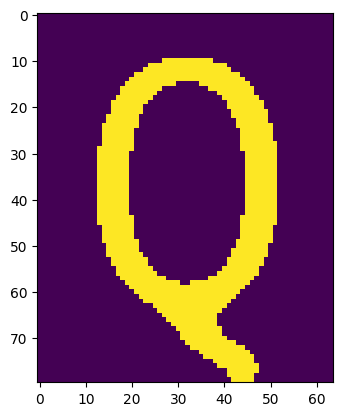

In [113]:
letter_img_blur_thresh = cv.inRange(letter_img_blur, 128, 255)
plt.imshow(letter_img_blur_thresh)

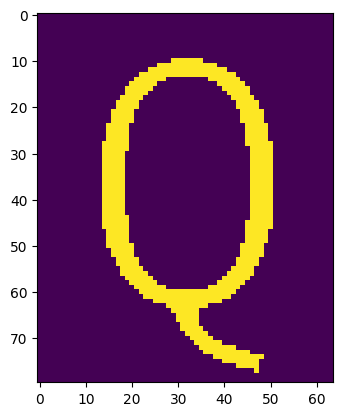

In [114]:
erosion_kernel = cv.getStructuringElement(cv.MORPH_RECT,(3,3)) # can do MORPH_RECT, MORPH_ELLIPSE, MORPH_CROSS
letter_img_erode = cv.erode(letter_img_thresh, erosion_kernel)
plt.imshow(letter_img_erode)

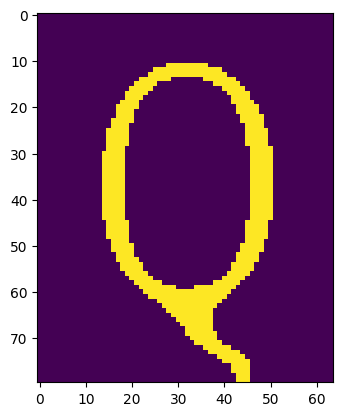

In [115]:
erosion_kernel = cv.getStructuringElement(cv.MORPH_RECT,(3,3))
letter_img_blur_erode = cv.erode(letter_img_blur_thresh, erosion_kernel)
plt.imshow(letter_img_blur_erode)

### Explanation of training data


In [ ]:
# Delete the 'train-letters' directory before running.

os.mkdir('train-letters/')
for i in range(26):
    letter = chr(ord('A') + i)
    os.mkdir('train-letters/' + str(i))
    for j in range(len(FONT_SIZES)):
        # Demonstration: generate ideal letter templates (font size 90, place (10, -7))
        blank_letter = np.zeros(LETTER_IMG_SHAPE, dtype=np.uint8)
        blank_letter_pil = Image.fromarray(blank_letter)
        # Get a drawing context
        draw = ImageDraw.Draw(blank_letter_pil)
        font_size = FONT_SIZES[j]
        font_location = FONT_SIZE_LOCATIONS[j]
        monospace = ImageFont.truetype("UbuntuMono-R.ttf", 
                                        font_size)
        draw.text(font_location, letter, fill=255, font=monospace)
        # Convert back to OpenCV image and save
        letter_img = np.array(blank_letter_pil)
        letter_img_thresh = cv.inRange(letter_img, 64, 255)
        cv.imwrite(os.path.join("train-letters", str(i), f"{letter}_{font_size}.png"), letter_img_thresh)